In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os

In [3]:
#!unzip -u "/content/drive/MyDrive/Internship/Fetal Cns-20230130T141456Z-001.zip" -d "/content/drive/MyDrive/Internship/"

In [4]:
#!unzip -u "/content/drive/MyDrive/Internship/Fetal Cns 2/Dataset/training_set.zip" -d "/content/drive/MyDrive/Internship/Fetal Cns 2/Dataset/"

In [5]:
test_csv = pd.read_csv("test_set_pixel_size (1).csv")
train_csv = pd.read_csv("training_set_pixel_size_and_HC.csv")
test_img = "/OneDrive/Desktop/minor project fetalhead/test_set/test_set"
train_img ="/OneDrive/Desktop/minor project fetalhead/training_set/training_set"

In [6]:
train_csv.head()

,filename,pixel size,head circumference (mm)
0,1_HC.png,0.069136,44.30
1,2_HC.png,0.089659,56.81
2,3_HC.png,0.062033,68.75
3,4_HC.png,0.091291,69.00
4,5_HC.png,0.061240,59.81


In [7]:
test_csv.head()

,filename,pixel size(mm)
0,000_HC.png,0.235857
1,001_HC.png,0.067973
2,002_HC.png,0.165202
3,003_HC.png,0.096674
4,004_HC.png,0.202203


In [8]:
import torch
import os
import cv2

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [10]:
def mask_generator(im):
  imgray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
  ret,thresh = cv2.threshold(imgray,127,255,0)
  contours, useless1 = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  ellipse = cv2.fitEllipse(contours[0])
  return cv2.ellipse(im,ellipse,(255,255,255),-1)

TypeError: Image data of dtype object cannot be converted to float

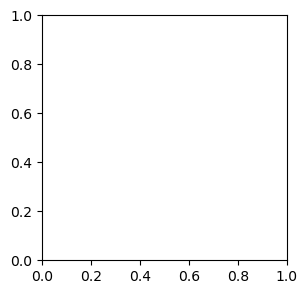

In [14]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (30,7))
for index in range(2):
  file_path = os.path.join(train_img, train_csv.iloc[index, 0].replace('.png','_Annotation.png'))

  ax = fig.add_subplot(2, 7, index+1)
  plt.imshow(cv2.imread(file_path))

  ax = fig.add_subplot(2, 7, index+8)
  plt.imshow(mask_generator(cv2.imread(file_path)))

In [13]:
for index in range(len(train_csv)):
    file_path = os.path.join('/training_set', train_csv.iloc[index, 0].replace('.png','_Annotation.png'))
    im = cv2.imread(file_path)
    mask = mask_generator(im)
    cv2.imwrite(file_path, mask)

error: OpenCV(4.8.1) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [ ]:
from tqdm import tqdm_notebook
import copy
import glob
from PIL import Image
import torchvision
import torch.utils.data
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
from torchvision import datasets

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np

In [ ]:
def generate_mask(source_file_path, dest_file_path):
    file_names = sorted([file for _,_,files in os.walk(source_file_path) for file in files])
    for i, file_name in enumerate(file_names):
        if i % 2 != 0:
            im = cv2.imread(source_file_path+file_name)
            imgray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
            ret,thresh = cv2.threshold(imgray,127,255,0)
            contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
            ellipse = cv2.fitEllipse(contours[0])
            im1 = cv2.ellipse(im,ellipse,(255,255,255),-1)
            image_name = file_name.replace('Annotation', 'Mask')
            cv2.imwrite(dest_file_path+image_name, im1)

    return 1

In [ ]:
generate_mask('/content/drive/MyDrive/Internship/Fetal Cns/Dataset/training_set/training_set/','/content/drive/MyDrive/Internship/Fetal Cns/Dataset/training_set/Masks/')



#Changing dataset to Torch form

In [ ]:
class CHALLENGE18(torch.utils.data.Dataset):
  def __init__(self, png_images, transform_X=None,transform_Y = None,train=True):
    self.X_train = glob.glob('/content/drive/MyDrive/Internship/Fetal Cns/Dataset/training_set/training_set/*HC.png')

    self.Y_train = glob.glob('/content/drive/MyDrive/Internship/Fetal Cns/Dataset/training_set/Masks/*')
    self.transform_X = transform_X
    self.transform_Y = transform_Y



    self.png_images = png_images

  def __len__(self):
    if self.png_images == "train":
      return len(self.X_train)
    else:
      print("code is wrong")

  def __getitem__(self,idx):
    if self.png_images == "train":

      X=np.array(Image.open(self.X_train[idx]).resize((572,572))).reshape(572,572,1) #as per U-net paper
      X = self.transform_X(X)
      # print(idx)
      # print(self.X_train[idx])
      name = self.X_train[idx].split('/')
      name2 = self.Y_train[idx].split('/')
      # print(name[7])
      # print(name2[7])
      Y=np.array(Image.open(self.Y_train[idx].replace(name2[7], name[7]).replace('_Mask.png','_Mask.png')).convert('L').resize((572,572))).reshape(572,572,1)
      Y = self.transform_Y(Y)

      #print(name2[8])
      #print(self.Y_train[idx].replace(name2[5], name[3]).replace('.png','_Mask.png'))

      return X, Y

    else:
      print("code is wrong")

#Normalizing image between [0,1]

In [ ]:
transform_X = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, ), (0.5, ))])
transform_Y = transforms.Compose([transforms.ToTensor()])
total_images = CHALLENGE18("train",transform_Y=transform_Y, transform_X = transform_X)

In [ ]:
len(total_images)

In [ ]:
x, y =total_images[555]

**Cross-checking the shape of x and y to being sure**

In [ ]:
x.shape

In [ ]:
y.shape

#for cross-validation, dividing the whole set in (90:10) ratio

In [ ]:
train_images = int(0.9 * len(total_images))
test_images = len(total_images)- train_images

train_data, validation_data = random_split(total_images,[train_images, test_images])

**Creating only train_loader & validation_loader here**

In [ ]:
batch_size = 2

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=True, num_workers=2)


In [ ]:
def imshow(img, title):
    img = img.clone().detach().numpy()
    print('npimage shape',img.shape)
    plt.show()
    return img

In [ ]:
def show_train_batch_images(dataloader):
    x, y = next(iter(dataloader))
    print(x.shape)
    return imshow(x[0],'d')

In [ ]:
p =show_train_batch_images(validation_loader)

In [ ]:
q= show_train_batch_images(train_loader)

In [ ]:
p.shape

In [ ]:
p=p.reshape(572,572)

In [ ]:
plt.imshow(p)

#preparing the U-net architecture

In [ ]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()


        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))



        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x

In [ ]:
class UNET(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNET, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return torch.sigmoid(x)

In [ ]:
model = UNET(1,1)
model.to(device)

**In the above cell using "model" name as to represent U-Net model..**

In [ ]:

import torch.optim as optim

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.00015)

#Dice coefficient

In [ ]:
def dice_coeff(y_pred, y_targets):


    smooth = 1
    num = y_targets.size(0)
    m1 = y_pred.view(num, -1)
    m2 = y_targets.view(num, -1)
    intersection = (m1 * m2)

    score = 2. * (intersection.sum(1) + smooth) / (m1.sum(1) + m2.sum(1) + smooth)
    score = score.sum() / num
    return score.item()

In [ ]:
def dice_loss(y_predict, y_train):

  dice_loss = 1 -(dice_coeff(y_predict, y_train))

  return dice_loss

#Training of the network

In [ ]:
epochs = 2
train_running_loss_history = []
validation_running_loss_history =[]

for e in range(epochs):
  train_running_loss = 0.0
  validation_running_loss = 0.0

  model.train()

  for ith_batch, sample_batched in enumerate(train_loader):
    X_train, y_train = sample_batched
    X_train= X_train.to(device)
    y_train= y_train.to(device)

    optimizer.zero_grad()
    y_pred = model(X_train)

    loss = 0.30 * dice_loss(y_pred, y_train) +  0.70 * criterion(y_pred, y_train)

    loss.backward()
    optimizer.step()

    if ith_batch % 50 == 0:
      print('Epoch: ', e + 1, 'Batch: ', ith_batch, 'Current Loss: ', loss.item())

    train_running_loss += loss.item()
  else:
    with torch.no_grad():

      model.eval()

      for ith_batch, sample_batched in enumerate(validation_loader):
          X_val, y_val = sample_batched
          X_val = X_val.to(device)
          y_val = y_val.to(device)

          y_out = model(X_val)
          out_val = (y_out + 0.5).int().float()

          val_loss = 0.3 * dice_loss(out_val, y_val)  + 0.7 * criterion(y_out, y_val)

          validation_running_loss += val_loss.item()
      print("================================================================================")
      print("Epoch {} completed".format(e + 1))

      train_epoch_loss = train_running_loss / len(train_loader)
      validation_epoch_loss = validation_running_loss / len(validation_loader)

      print("Average train loss is {}: ".format(train_epoch_loss))
      print("Average validation loss is {}".format(validation_epoch_loss))
      print("================================================================================")
      train_running_loss_history.append(train_epoch_loss)
      validation_running_loss_history.append(validation_epoch_loss)

  torch.cuda.empty_cache()

#plot for validation & training loss respectively

In [ ]:
plt.plot(validation_running_loss_history, label = 'Validation Loss', color='green')
plt.plot(train_running_loss_history, label = 'Train Loss',  color='red')
plt.legend()

**We can see that both the losses are decreasing**

In [ ]:
model.eval()
X_train.size()

In [ ]:
out = (y_pred + 0.5).int().float()

In [ ]:
print(dice_coeff(y_train, out))
print(dice_loss(y_train, out))

In [ ]:
class HC18_test(Dataset):
    def __init__(self, root_dir, transform_X = None):
        self.pixel_file = test_csv
        self.root_dir = root_dir
        self.transform_X = transform_X

    def __len__(self):
        return len(self.pixel_file)

    def __getitem__(self, index):
        imx_name = os.path.join(self.root_dir, '', self.pixel_file.iloc[index, 0])

        imx = Image.open(imx_name)

        f_name = self.pixel_file.iloc[index, 0]

        if self.transform_X :
            imx = self.transform_X(imx)

        sample = {'image': imx, 'f_name': f_name}
        return sample

In [ ]:
test_img = HC18_test('/content/drive/MyDrive/Internship/Fetal Cns/Dataset/test_set', transform_X = transform_X)

**Creating test-loader to work with test images**

In [ ]:
test_loader = torch.utils.data.DataLoader(test_img, batch_size=batch_size,shuffle=False)

In [ ]:
def avg_dice_index(dataloader):

    dice = 0.0
    model.eval()
    with torch.no_grad():

        for ith_batch, sample_batched in enumerate(dataloader):
            X_train , y_train = sample_batched
            X_train = X_train.to(device)
            y_train = y_train.to(device)
            # print(model(X_train))

            y_predict = (model(X_train) + 0.5).int().float()
            # print(y_predict)

            dice += dice_coeff(y_predict, y_train)

    avg_dice = dice / len(dataloader)
    # print(avg_dice)
    return avg_dice

In [ ]:
test_loader = DataLoader(dataset = test_img, batch_size = 1, shuffle = True)

#Writing in the Drive

In [ ]:
transform = transforms.Compose([transforms.ToPILImage(),transforms.Resize((540, 800)),transforms.ToTensor()])

with torch.no_grad():

      for ith_batch , data in enumerate(test_loader):
        X_test = data['image']
        X_test = X_test.to(device)

        y_pred = (model(X_test) + 0.5).int().float().cpu()

        file_names = data['f_name']
        Result = transform(y_pred[0])
        torchvision.utils.save_image(Result , os.path.join('/content/drive/MyDrive/Internship/Fetal Cns/Dataset/segmentation_test_2/', file_names[0]))
      print("task to write file is complete")


**Function to create mask of test_set**

In [ ]:
def test_ellipse(im):
    imgray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(imgray,127,255,0)
    # im2,
    contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    contour_sizes = [len(contour) for contour in contours]
    ellipse = cv2.fitEllipse(contours[np.argmax(contour_sizes)])
    return ellipse


# **Formula to Calculate Head Circumference**

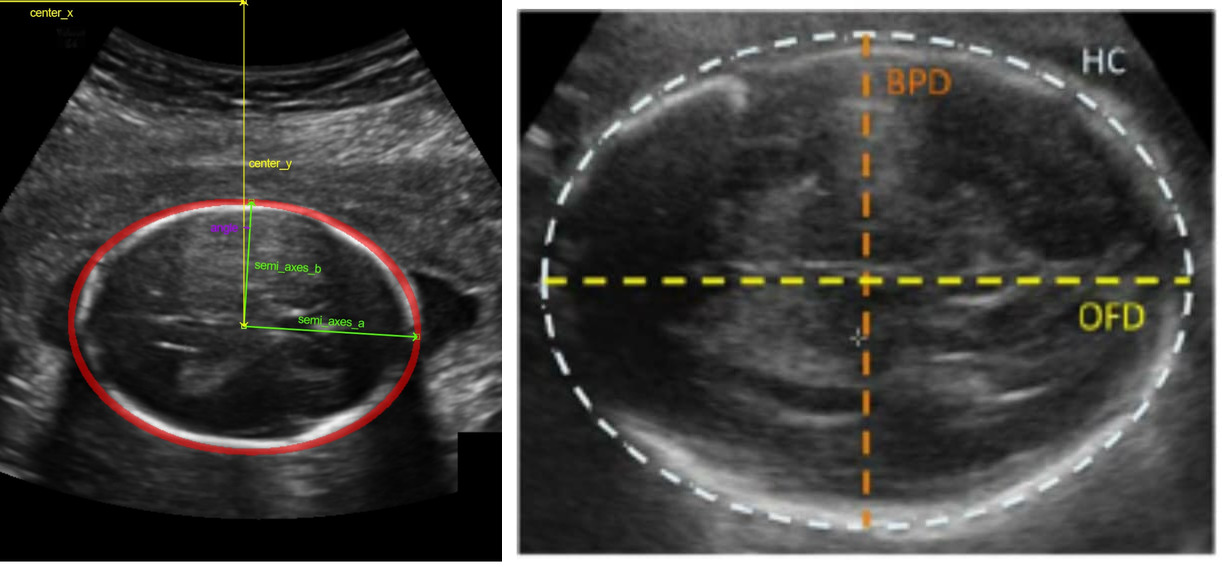

In [ ]:
# occipitofrontal diameter (OFD)
#BPD (biparietal diameter), the diameter of your baby's head
#HC = 1.62 × (BPD + OFD) 3
# OFD = 2(semi_axes_a)
# BPD = 2(semi_axes_b)

#Creating a csv file to store the Data

In [ ]:
submission = {'filename': [], 'center_x_mm': [], 'center_y_mm': [], 'semi_axes_a_mm': [],
             'semi_axes_b_mm': [], 'angle_rad': [], 'Index': []}



file_names = sorted([file for _,_,files in os.walk('/content/drive/MyDrive/Internship/Fetal Cns/Dataset/segmentation_test_2/') for file in files])

for i, file_name in enumerate(file_names):
    im = cv2.imread('/content/drive/MyDrive/Internship/Fetal Cns/Dataset/segmentation_test_2/'+file_name)

    ellipse = test_ellipse(im)
    im_mask = cv2.ellipse(np.zeros_like(im),ellipse,(255,255,255),-1,100)
    image_name = file_name.split('.')[0] + '_Annotation_fit.png'


    pixel_size = test_csv.loc[test_csv['filename'] == file_name, 'pixel size(mm)'].iloc[0]
    submission['filename'].extend([file_name])
    submission['Index'].extend([int(file_name.split('_')[0])])
    center_x,  center_y = ellipse[0]
    submission['center_x_mm'].extend([pixel_size*center_x])
    submission['center_y_mm'].extend([pixel_size*center_y])
    semi_axes_b, semi_axes_a = ellipse[1]
    if semi_axes_b > semi_axes_a:
        semi_axes_b = semi_axes_b + semi_axes_a
        semi_axes_a = semi_axes_b - semi_axes_a
        semi_axes_b -= semi_axes_a
    submission['semi_axes_a_mm'].extend([semi_axes_a*pixel_size/2])
    submission['semi_axes_b_mm'].extend([semi_axes_b*pixel_size/2])
    angle = ellipse[2]
    if angle < 90:
        angle += 90
    else:
        angle -= 90
    submission['angle_rad'].extend([np.deg2rad(angle)])
    #OFD,  BPD = ellipse[3]
    #submission['OFD'].extend([semi_axes_a_mm*2])
    #submission['BPD'].extend([semi_axes_b*2])
    #submission['Head Circumfrence'].extend([1.62*(BPD + OFD)^3])
submission = pd.DataFrame(submission)
submission = submission[['filename', 'center_x_mm', 'center_y_mm',
                         'semi_axes_a_mm', 'semi_axes_b_mm', 'angle_rad', 'Index']]
submission = submission.sort_values(['Index'])
submission = submission.drop('Index', axis=1)
submission.to_csv("/content/drive/MyDrive/Internship/Fetal Cns/final1_result.csv", index=False)
print('Required .csv file generated')
print(ellipse)

In [ ]:

final_result = pd.read_csv('/content/drive/MyDrive/Internship/Fetal Cns/final1_result.csv')

In [ ]:
#HeadCircumfrence = 1.62*(BPD + OFD)^3
#HeadCircumfrence

In [ ]:
final_result.head()

In [ ]:
len(final_result)

##Caculating The Head Circumfrence

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Internship/Fetal Cns/final1_result.csv")

In [ ]:
df['OFD']= np.round(df.semi_axes_a_mm*2,1)

In [ ]:
df['BPD']= np.round(df.semi_axes_b_mm*2,1)

In [ ]:
b = np.round(df.BPD,1)

In [ ]:
c= np.round(df.OFD,1)

In [ ]:
d = b+c
e=d*d*d
f=(1.62*e)
g=np.round(f**(1/3),1)
h=g/10

In [ ]:
df['Head_Circumfrence_cm']= h

In [ ]:
df.head()

## Adding Gestational Age Data

In [ ]:
import numpy as np
# Gestational Age
conditions = [
    (df['Head_Circumfrence_cm'] < 8.00),
    (df['Head_Circumfrence_cm'] >= 8.00) & (df['Head_Circumfrence_cm'] <= 9.00),#week13
    (df['Head_Circumfrence_cm'] > 9.01) & (df['Head_Circumfrence_cm'] <= 10.49),#week14
    (df['Head_Circumfrence_cm'] >10.50 ) & (df['Head_Circumfrence_cm'] <= 12.49),#week15
    (df['Head_Circumfrence_cm'] >12.50 ) & (df['Head_Circumfrence_cm'] <= 13.49),#week16
    (df['Head_Circumfrence_cm'] >13.50 ) & (df['Head_Circumfrence_cm'] <= 14.99),#week17
    (df['Head_Circumfrence_cm'] >15.00 ) & (df['Head_Circumfrence_cm'] <= 16.49),#week18
    (df['Head_Circumfrence_cm'] >16.50 ) & (df['Head_Circumfrence_cm'] <= 17.49),#week19
    (df['Head_Circumfrence_cm'] >17.50 ) & (df['Head_Circumfrence_cm'] <= 18.99),#week20
    (df['Head_Circumfrence_cm'] >19.00 ) & (df['Head_Circumfrence_cm'] <= 19.99),#week21
    (df['Head_Circumfrence_cm'] >20.00 ) & (df['Head_Circumfrence_cm'] <= 20.99),#week22
    (df['Head_Circumfrence_cm'] >21.00 ) & (df['Head_Circumfrence_cm'] <= 22.49),#week23
    (df['Head_Circumfrence_cm'] >22.50 ) & (df['Head_Circumfrence_cm'] <= 22.99),#week24
    (df['Head_Circumfrence_cm'] >= 23.00) & (df['Head_Circumfrence_cm'] <= 23.99),#week25
    (df['Head_Circumfrence_cm'] > 24.00) & (df['Head_Circumfrence_cm'] <= 24.79),#week26
    (df['Head_Circumfrence_cm'] >24.80 ) & (df['Head_Circumfrence_cm'] <= 25.60),#week27
    (df['Head_Circumfrence_cm'] >25.61 ) & (df['Head_Circumfrence_cm'] <= 26.75),#week28
    (df['Head_Circumfrence_cm'] >26.76 ) & (df['Head_Circumfrence_cm'] <= 27.75),#week29
    (df['Head_Circumfrence_cm'] >27.76 ) & (df['Head_Circumfrence_cm'] <= 28.85),#week30
    (df['Head_Circumfrence_cm'] >28.86 ) & (df['Head_Circumfrence_cm'] <= 29.60),#week31
    (df['Head_Circumfrence_cm'] >29.61 ) & (df['Head_Circumfrence_cm'] <= 30.40),#week32
    (df['Head_Circumfrence_cm'] >30.41 ) & (df['Head_Circumfrence_cm'] <= 31.20),#week33
    (df['Head_Circumfrence_cm'] >31.21 ) & (df['Head_Circumfrence_cm'] <= 31.80),#week34
    (df['Head_Circumfrence_cm'] >31.81 ) & (df['Head_Circumfrence_cm'] <= 32.50),#week35
    (df['Head_Circumfrence_cm'] >32.51 ) & (df['Head_Circumfrence_cm'] <= 33.00),#week36
    (df['Head_Circumfrence_cm'] >33.01 ) & (df['Head_Circumfrence_cm'] <= 33.70),#week37
    (df['Head_Circumfrence_cm'] >33.71 ) & (df['Head_Circumfrence_cm'] <= 34.20),#week38
    (df['Head_Circumfrence_cm'] >34.21 ) & (df['Head_Circumfrence_cm'] <= 35.00),#week39
    (df['Head_Circumfrence_cm'] >35.00 ) & (df['Head_Circumfrence_cm'] <= 36.00),#week40
    (df['Head_Circumfrence_cm'] > 36)
    ]

# create a list of the values we want to assign for each condition
values = ['Fetus is less than 8 Menstrual Weeks','13','14','15','16','17','18','19','20','21','22',
          '23','24','25', '26', '27', '28','29','30','31','32','33','34','35','36','37','38','39','40','Abnormal']


df['Gestational_Age_In_Weeks'] = np.select(conditions, values)


df.head(10)

In [ ]:
df.to_csv("/content/drive/MyDrive/Internship/Fetal Cns/Head_Circumfrence.csv")